### Importação das bibliotecas

In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import BatchNormalization, Input, concatenate, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, RMSprop

from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, confusion_matrix

### Leitura do conjunto de dados

In [2]:
os.mkdir('augmented')
os.mkdir('/kaggle/working/augmented/benign')
os.mkdir('/kaggle/working/augmented/malignant')

In [3]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

### Carregamento dos dados de cada classe

In [4]:
benign=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in benign:
    if f.endswith('.png'):
        
        shutil.copy(f,'augmented/benign')
        
malignant=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in malignant:
    if f.endswith('.png'):
        
        shutil.copy(f,'augmented/malignant')

In [5]:
benign=getListOfFiles('/kaggle/working/augmented/benign')
malignant=getListOfFiles('/kaggle/working/augmented/malignant')

### Visualização dos dados

In [6]:
from tensorflow.keras.preprocessing import image

In [7]:
total_images = len(benign) + len(malignant)
print(total_images)

7909


### Gerando targets

In [8]:
import pandas as pd

In [9]:
data = pd.DataFrame(index=np.arange(0, len(benign) + len(malignant)), columns=["image", "target"])

In [10]:
k=0
for c in [0,1]:
        if c==0:
            for m in range(len(benign)):
                data.iloc[k]["image"] = benign[m]
                data.iloc[k]["target"] = 0
                k += 1

        else:
            for m in range(len(malignant)):
                data.iloc[k]["image"] = malignant[m]
                data.iloc[k]["target"] = 1
                k += 1            

In [11]:
data.shape

(7909, 2)

### Verificando desbalanceamento dos dados

In [12]:
count_data = data["target"].value_counts()
count_data

1    5429
0    2480
Name: target, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


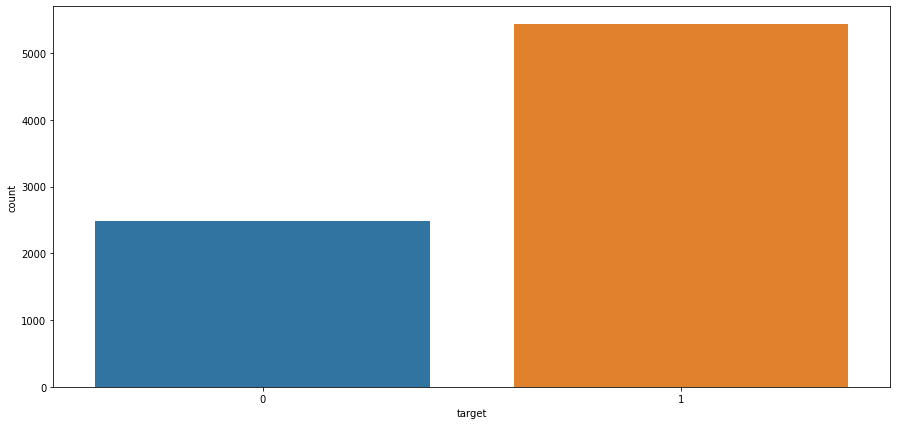

In [13]:
import seaborn as sns
ax = plt.subplots(figsize = (15,7))
target = sns.countplot(data["target"])
plt.show()

In [14]:
from sklearn.utils import resample

In [15]:
ben_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)

up_sampled = pd.concat([data[data['target']==1], ben_upsampled])

up_sampled['target'].value_counts()

1    5429
0    5429
Name: target, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


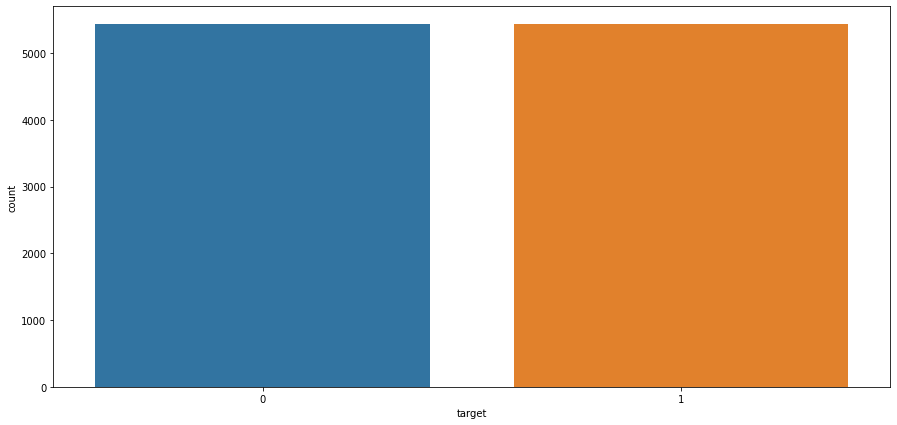

In [16]:
import seaborn as sns
ax = plt.subplots(figsize = (15,7))
target = sns.countplot(up_sampled["target"])
plt.show()

In [17]:
up_sampled.shape

(10858, 2)

In [18]:
up_sampled

,image,target
2480,/kaggle/working/augmented/malignant/SOB_M_DC-1...,1
2481,/kaggle/working/augmented/malignant/SOB_M_DC-1...,1
2482,/kaggle/working/augmented/malignant/SOB_M_DC-1...,1
2483,/kaggle/working/augmented/malignant/SOB_M_DC-1...,1
2484,/kaggle/working/augmented/malignant/SOB_M_PC-1...,1
...,...,...
1627,/kaggle/working/augmented/benign/SOB_B_A-14-22...,0
27,/kaggle/working/augmented/benign/SOB_B_F-14-23...,0
1985,/kaggle/working/augmented/benign/SOB_B_TA-14-3...,0
1560,/kaggle/working/augmented/benign/SOB_B_TA-14-1...,0


In [19]:
from tqdm import tqdm

In [20]:
from tensorflow.keras.utils import to_categorical

In [21]:
from PIL import Image

In [22]:
train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = image.load_img(up_sampled['image'].iloc[i], target_size=(64,64), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)


100%|██████████| 10858/10858 [03:01<00:00, 59.96it/s]


In [23]:
from sklearn.model_selection import train_test_split

X = np.array(train_image)
y = up_sampled.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(7600, 64, 64, 3)
(3258, 64, 64, 3)


### Transferência de conhecimento

In [24]:
from tensorflow.keras.models import load_model, model_from_json

In [25]:
from tensorflow.keras.optimizers import SGD, RMSprop

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [27]:
def create_model():
    model_resnet = ResNet50(weights=None,
                        include_top=False, 
                        input_shape=(64, 64, 3))
    
    
    model = Sequential(model_resnet, name='dense2')
    model.add(Flatten(name='flatten2'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu', name='dense1', kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))   
    model.summary()
    
    sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rms = RMSprop(learning_rate=2e-5)
    
    model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['acc',f1_m])
    
    return model

In [28]:
model = create_model()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "dense2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten2 (Flatten)           (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense1 (Dense)               (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 25,718,145
Trainable params: 25,648,641
Non-trainable params: 69,504
___________________________________________

In [29]:
X_train=np.asarray(X_train).astype(np.int)

In [30]:
y_train=np.asarray(y_train).astype(np.int)

In [31]:
X_test=np.asarray(X_test).astype(np.int) 

In [32]:
y_test=np.asarray(y_test).astype(np.int)

In [33]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 50, validation_data=(X_test, y_test))

2021-11-11 23:49:31.591348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
238/238 [==============================] - 269s 1s/step - loss: 28.0432 - acc: 0.5368 - f1_m: 0.5116 - val_loss: 26.8001 - val_acc: 0.5061 - val_f1_m: 0.6660
Epoch 2/50
238/238 [==============================] - 260s 1s/step - loss: 25.6733 - acc: 0.5558 - f1_m: 0.5395 - val_loss: 24.6192 - val_acc: 0.5043 - val_f1_m: 0.6604
Epoch 3/50
238/238 [==============================] - 255s 1s/step - loss: 23.4373 - acc: 0.5722 - f1_m: 0.5471 - val_loss: 22.3982 - val_acc: 0.5169 - val_f1_m: 0.6406
Epoch 4/50
238/238 [==============================] - 260s 1s/step - loss: 21.3751 - acc: 0.5797 - f1_m: 0.5537 - val_loss: 20.3430 - val_acc: 0.6166 - val_f1_m: 0.5969
Epoch 5/50
238/238 [==============================] - 258s 1s/step - loss: 19.4942 - acc: 0.5830 - f1_m: 0.5621 - val_loss: 18.6149 - val_acc: 0.6111 - val_f1_m: 0.5677
Epoch 6/50
238/238 [==============================] - 258s 1s/step - loss: 17.7962 - acc: 0.5953 - f1_m: 0.5658 - val_loss: 16.9922 - val_acc: 0.5703 - val

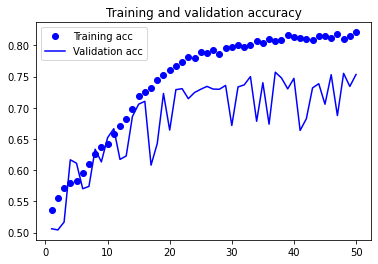

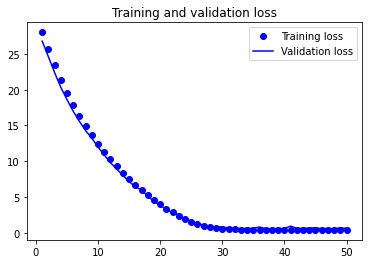

In [34]:
acc = history.history['acc']

val_acc = history.history['val_acc'] 
loss = history.history['loss']
val_loss = history.history['val_loss']; 
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

In [35]:
loss, accuracy, f1_score = model.evaluate(X_train, y_train, verbose=0)

In [36]:
print('val_accuracy', accuracy)
print('f1_score', f1_score)

val_accuracy 0.8311842083930969
f1_score 0.7917793989181519
